# Out-Of-Sample Predictions

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy.special import expit as inverse_logit
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Generate Sample Data

We want to fit a logistic regression model where there is a multiplicative interaction between two numerical features.

In [3]:
# Number of data points
n = 250
# Create features
x1 = rng.normal(loc=0.0, scale=2.0, size=n)
x2 = rng.normal(loc=0.0, scale=2.0, size=n)
# Define target variable
intercept = -0.5
beta_x1 = 1
beta_x2 = -1
beta_interaction = 2
z = intercept + beta_x1 * x1 + beta_x2 * x2 + beta_interaction * x1 * x2
p = inverse_logit(z)
# note binomial with n=1 is equal to a Bernoulli
y = rng.binomial(n=1, p=p, size=n)
df = pd.DataFrame(dict(x1=x1, x2=x2, y=y))
df.head()

,x1,x2,y
0,-0.445284,1.381325,0
1,2.651317,0.800736,1
2,-1.141940,-0.128204,0
3,1.336498,-0.931965,0
4,2.290762,3.400222,1


Let us do some exploration of the data:

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


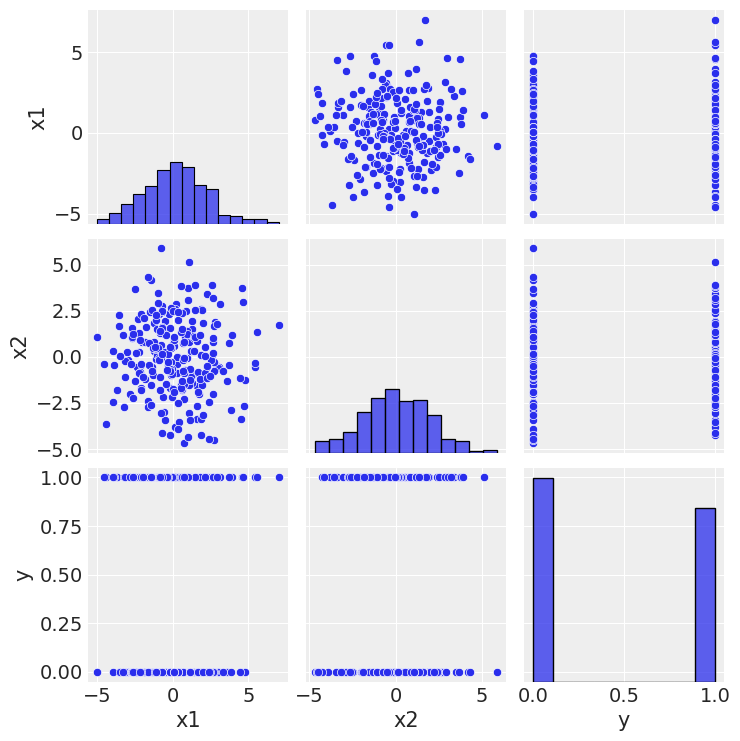

In [4]:
sns.pairplot(data=df, kind="scatter");

* $x_1$ and $x_2$ are not correlated.
* $x_1$ and $x_2$ do not seem to separate the $y$ -classes independently.
* The distribution of $y$ is not highly unbalanced.

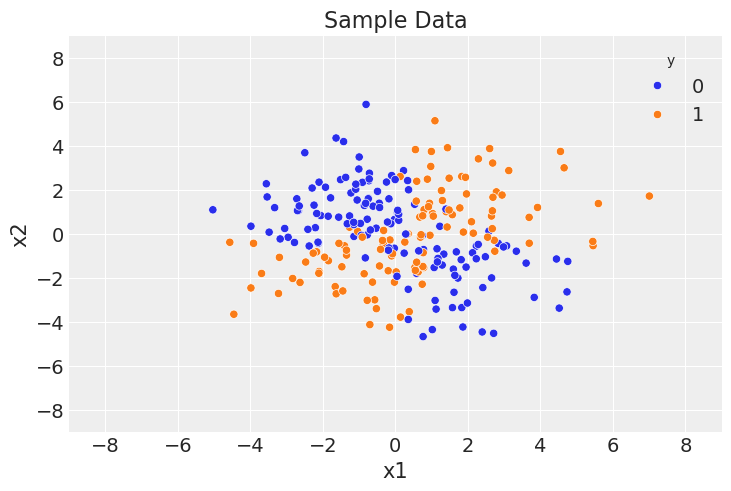

In [5]:
fig, ax = plt.subplots()
sns.scatterplot(x="x1", y="x2", data=df, hue="y")
ax.legend(title="y")
ax.set(title="Sample Data", xlim=(-9, 9), ylim=(-9, 9));

## Prepare Data for Modeling

In [6]:
labels = ["Intercept", "x1", "x2", "x1:x2"]
df["Intercept"] = np.ones(len(df))
df["x1:x2"] = df["x1"] * df["x2"]
# reorder columns to be in the same order as labels
df = df[labels]
x = df.to_numpy()

Now we do a train-test split.

In [7]:
indices = rng.permutation(x.shape[0])
train_prop = 0.7
train_size = int(train_prop * x.shape[0])
training_idx, test_idx = indices[:train_size], indices[train_size:]
x_train, x_test = x[training_idx, :], x[test_idx, :]
y_train, y_test = y[training_idx], y[test_idx]

## Define and Fit the Model

We now specify the model in PyMC.

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


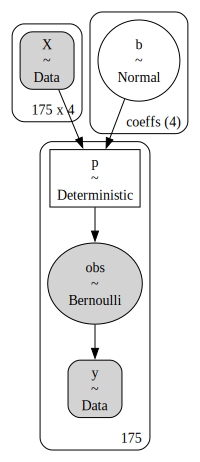

In [8]:
coords = {"coeffs": labels}

with pm.Model(coords=coords) as model:
    # data containers
    X = pm.MutableData("X", x_train)
    y = pm.MutableData("y", y_train)
    # priors
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    # linear model
    mu = pm.math.dot(X, b)
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)

pm.model_to_graphviz(model)

In [9]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


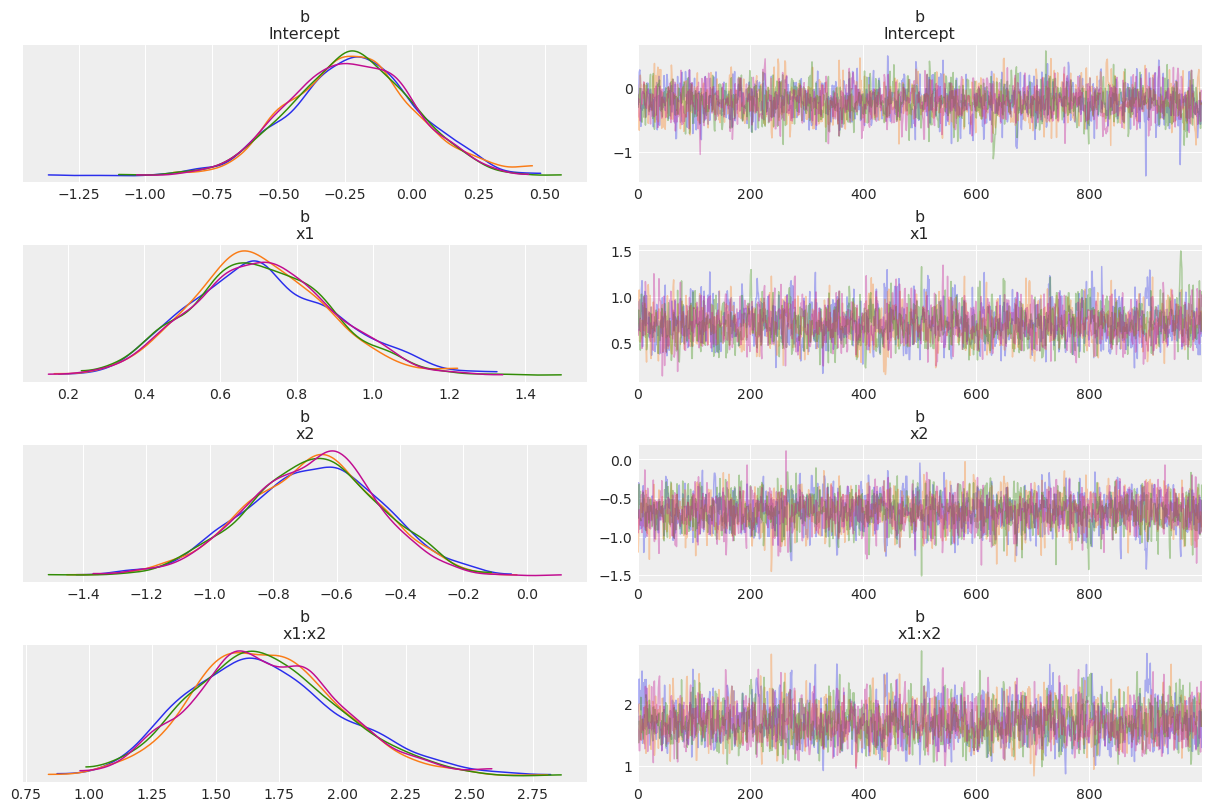

In [10]:
az.plot_trace(idata, var_names="b", compact=False);

The chains look good.

In [11]:
az.summary(idata, var_names="b")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[Intercept],-0.224,0.230,-0.651,0.202,0.004,0.003,2716.0,2500.0,1.0
b[x1],0.709,0.184,0.388,1.066,0.004,0.003,2425.0,2549.0,1.0
b[x2],-0.679,0.210,-1.057,-0.283,0.004,0.003,3013.0,2743.0,1.0
b[x1:x2],1.702,0.293,1.158,2.249,0.006,0.004,2346.0,2295.0,1.0


And we do a good job of recovering the true parameters for this simulated dataset.

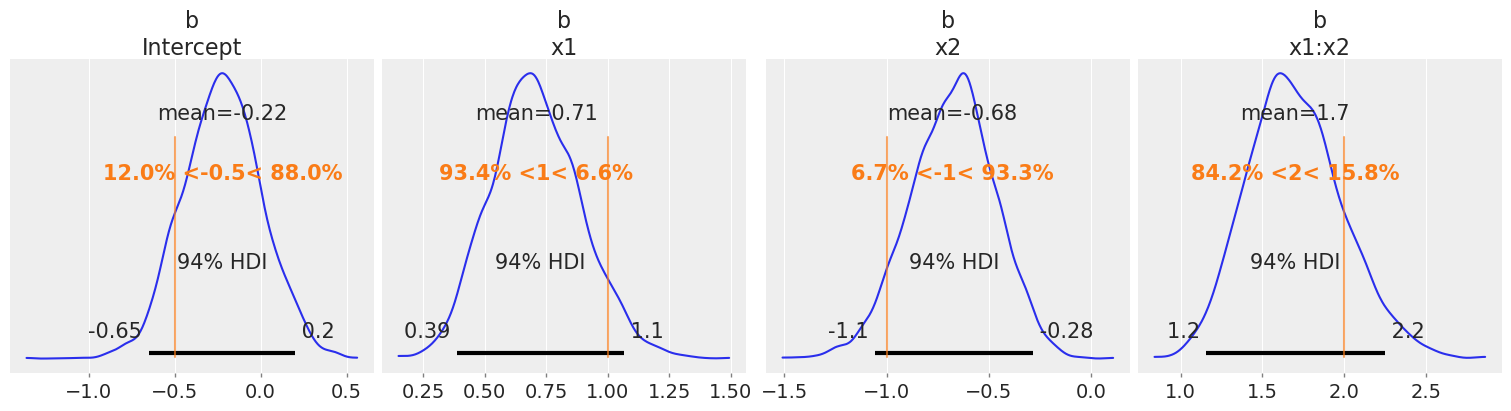

In [12]:
az.plot_posterior(
    idata, var_names=["b"], ref_val=[intercept, beta_x1, beta_x2, beta_interaction], figsize=(15, 4)
);

## Generate Out-Of-Sample Predictions

Now we generate predictions on the test set.

In [13]:
with model:
    pm.set_data({"X": x_test, "y": y_test})
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [14]:
# Compute the point prediction by taking the mean and defining the category via a threshold.
p_test_pred = idata.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int").to_numpy()

## Evaluate Model

First let us compute the accuracy on the test set.

In [15]:
print(f"accuracy = {np.mean(y_test==y_test_pred): 0.3f}")

accuracy =  0.907


Next, we plot the [roc curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and compute the [auc](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

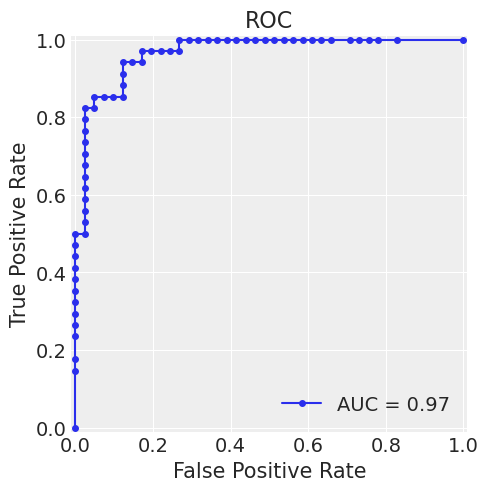

In [16]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");

The model is performing as expected (we of course know the data generating process, which is almost never the case in practical applications).

## Model Decision Boundary

Finally we will describe and plot the model decision boundary, which is the space defined as

$$
\mathcal{B} = \bigl \{ (x_1, x_2) \in \mathbb{R}^2 | p (x_1, x_2) = 0.5 \bigr \}
$$

where $p$ denotes the probability of belonging to the class $y = 1$ output by the model. To make this set explicit, we simply write the condition in terms of the model parametrization:

$$
0.5 = \frac{1}{ 1 + exp \bigl ( - ( \beta_0 + \beta_1 x_1 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1 x_2 ) \bigr ) }
$$

which implies

$$
0 = \beta_0 + \beta_1 x_1 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1 x_2
$$

Solving for $x_2$ we get the formula

$$
x_2 = - \frac{\beta_0 + \beta_1 x_1}{\beta_2 + \beta _{12}x_1}
$$

Observe that this curve is a hyperbola centered at the singularity point $x_1 = - \beta_2 / \beta_{12}$
.

Let us now plot the model decision boundary using a grid:

In [17]:
def make_grid():
    x1_grid = np.linspace(start=-9, stop=9, num=300)
    x2_grid = x1_grid
    x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)
    x_grid = np.stack(arrays=[x1_mesh.flatten(), x2_mesh.flatten()], axis=1)
    return x1_grid, x2_grid, x_grid


x1_grid, x2_grid, x_grid = make_grid()

with model:
    # Create features on the grid.
    x_grid_ext = np.hstack(
        (
            np.ones((x_grid.shape[0], 1)),
            x_grid,
            (x_grid[:, 0] * x_grid[:, 1]).reshape(-1, 1),
        )
    )
    # set the observed variables
    pm.set_data({"X": x_grid_ext})
    # calculate pushforward values of `p`
    ppc_grid = pm.sample_posterior_predictive(idata, var_names=["p"])

Sampling: []


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [18]:
# grid of predictions
grid_df = pd.DataFrame(x_grid, columns=["x1", "x2"])
grid_df["p"] = ppc_grid.posterior_predictive.p.mean(dim=["chain", "draw"])
p_grid = grid_df.pivot(index="x2", columns="x1", values="p").to_numpy()

Now we compute the model decision boundary on the grid for visualization purposes.

In [19]:
def calc_decision_boundary(idata, x1_grid):
    # posterior mean of coefficients
    intercept = idata.posterior["b"].sel(coeffs="Intercept").mean().data
    b1 = idata.posterior["b"].sel(coeffs="x1").mean().data
    b2 = idata.posterior["b"].sel(coeffs="x2").mean().data
    b1b2 = idata.posterior["b"].sel(coeffs="x1:x2").mean().data
    # decision boundary equation
    return -(intercept + b1 * x1_grid) / (b2 + b1b2 * x1_grid)

We finally get the plot and the predictions on the test set:

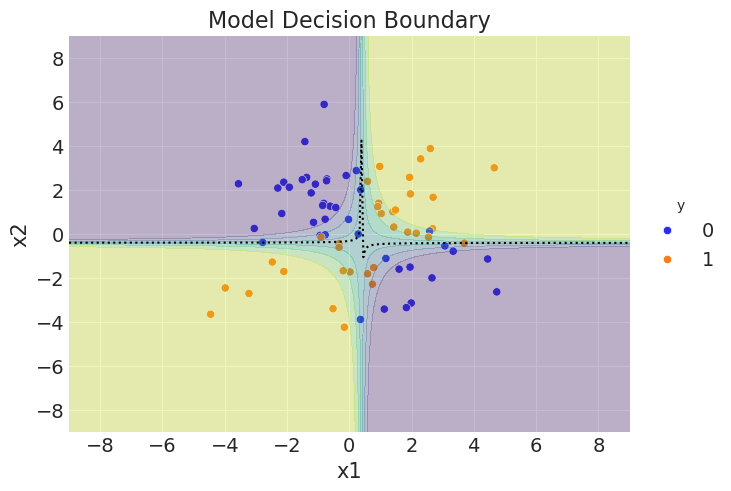

In [20]:
fig, ax = plt.subplots()

# data
sns.scatterplot(
    x=x_test[:, 1].flatten(),
    y=x_test[:, 2].flatten(),
    hue=y_test,
    ax=ax,
)

# decision boundary
ax.plot(x1_grid, calc_decision_boundary(idata, x1_grid), color="black", linestyle=":")

# grid of predictions
ax.contourf(x1_grid, x2_grid, p_grid, alpha=0.3)

ax.legend(title="y", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Model Decision Boundary", xlim=(-9, 9), ylim=(-9, 9), xlabel="x1", ylabel="x2");

Note that we have computed the model decision boundary by using the mean of the posterior samples. However, we can generate a better (and more informative!) plot if we use the complete distribution (similarly for other metrics like accuracy and AUC).

## References
* [Bayesian Analysis with Python (Second edition) - Chapter 4](https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb)
* [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)

##Authors
* Created by [Juan Orduz](https://github.com/juanitorduz).
* Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) to PyMC v4 in June 2022
* Re-executed by [Benjamin T. Vincent](https://github.com/drbenvincent) with PyMC v5 in December 2022
* Updated by [Christian Luhmann](https://github.com/cluhmann) in December 2023 ([pymc-examples#616](https://github.com/pymc-devs/pymc-examples/pull/616))

## Watermark

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Tue Jun 18 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

pytensor: 2.22.1

pandas    : 2.2.2
numpy     : 1.26.4
pymc      : 5.15.1
matplotlib: 3.8.4
arviz     : 0.18.0
seaborn   : 0.13.2

Watermark: 2.4.3



## License notice
All the notebooks in this example gallery are provided under the [MIT License](https://github.com/pymc-devs/pymc-examples/blob/main/LICENSE) which allows modification, and redistribution for any use provided the copyright and license notices are preserved.

## Citing PyMC examples
To cite this notebook, use the DOI provided by Zenodo for the pymc-examples repository.

Important

Many notebooks are adapted from other sources: blogs, books… In such cases you should cite the original source as well.

Also remember to cite the relevant libraries used by your code.

Here is an citation template in bibtex:

```py
@incollection{citekey,
  author    = "<notebook authors, see above>",
  title     = "<notebook title>",
  editor    = "PyMC Team",
  booktitle = "PyMC examples",
  doi       = "10.5281/zenodo.5654871"
}
```
which once rendered could look like:

PyMC Contributors . "Out-Of-Sample Predictions". In: PyMC Examples. Ed. by PyMC Team. DOI: [10.5281/zenodo.5654871](https://doi.org/10.5281/zenodo.5654871)